In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import pypsa
import yaml

In [10]:
with open('../config.yaml', 'r') as configfile:
    config = yaml.safe_load(configfile)

TY = config['scenario']['target_years'][0]

simulation_year = config['scenario']['simulation_years'][0]

basedir = f'/srv/ES2050/ensym/DestinE/ERAA/scenario_{TY}_{simulation_year}/'

scenario = f'National estimates {TY}'

network_f = f'../networks/pilot_base_TY{TY}_{simulation_year}.nc' # snakemake input!

generator_types = config['generation']['generator_types']

FuelType = config['generation']['fuel_types']

storage_types = config['storage']['storage_types']

storage_efficiencies = config['storage']['storage_efficiencies']

storage_soc_initial = config['storage']['soc_initial']

capacities = pd.read_csv(basedir+f'generation_technical_{TY}.csv', header=0, index_col=0)

sus_energy = pd.read_csv(basedir+f'storage_technical_{TY}.csv', header=0, index_col=0)

In [11]:
network = pypsa.Network(network_f)
network.name = 'DestinE Pilot with electricity'

INFO:pypsa.io:Imported network pilot_base_TY2030_2010.nc has buses, carriers, links


In [12]:
### add generators
capacities["technology"] = capacities["technology"].str.strip() 
gen_specs = capacities.loc[capacities.index[capacities.technology.isin(generator_types)],:]

gen_specs.technology = gen_specs.technology.map(config['carriers_short_names']).astype(str)
gen_specs['name'] = gen_specs[['node', 'technology']].agg(' '.join, axis=1)
gen_specs.set_index('name', inplace=True)

network.madd('Carrier', gen_specs.technology.unique())
network.madd('Generator', gen_specs.index, bus=gen_specs.node, carrier=gen_specs.technology, p_nom=gen_specs.nominal_capacity, marginal_cost=gen_specs.marginal_cost)

Index(['UA00 nuclear', 'UA00 coal', 'UA00 gas', 'UA00 ror', 'UA00 onwind',
       'UA00 CSP', 'UA00 solar', 'UA00 other RE'],
      dtype='object', name='name')


Index(['BE00 nuclear', 'BG00 nuclear', 'CH00 nuclear', 'CZ00 nuclear',
       'ES00 nuclear', 'FI00 nuclear', 'FR00 nuclear', 'HU00 nuclear',
       'NL00 nuclear', 'RO00 nuclear',
       ...
       'BE00 biofuel', 'DKE1 biofuel', 'DKW1 biofuel', 'EE00 biofuel',
       'FI00 biofuel', 'HU00 biofuel', 'IE00 biofuel', 'NL00 biofuel',
       'SK00 biofuel', 'UKNI biofuel'],
      dtype='object', name='name', length=350)

In [13]:
capacities.technology.unique()

array(['Nuclear', 'Lignite', 'Hard Coal', 'Gas', 'Oil', 'Electrolyser',
       'Hydro - Pondage (Turbine)', 'Hydro - Run of River (Turbine)',
       'Hydro - Reservoir (Turbine)',
       'Hydro - Pump Storage Open Loop (Turbine)',
       'Hydro - Pump Storage Closed Loop (Turbine)',
       'Hydro - Pump Storage Open Loop (Pumping)',
       'Hydro - Pump Storage Closed Loop (Pumping)',
       'Batteries (Injection)', 'Batteries (Offtake)', 'Wind Onshore',
       'Wind Offshore', 'Solar (Thermal)', 'Solar (Photovoltaic)',
       'Others renewable', 'Others non-renewable', 'Biofuel',
       'Demand Side Response capacity'], dtype=object)

In [7]:
generator_types

['Nuclear',
 'Lignite',
 'Hard Coal',
 'Oil shale',
 'Gas',
 'Wind Onshore',
 'Wind Offshore',
 'Solar (Photovoltaic)',
 'Solar (Thermal)',
 'Hydro - Run of River (Turbine)',
 'Others renewable',
 'Biofuel',
 'Others non-renewable',
 'Demand Side Response Capacity']

In [76]:
### add stores
sus_id = pd.Index([c if (capacities.technology[c].split(' (')[0] in storage_types) & (capacities.technology[c] not in generator_types) else np.nan
                   for c in capacities.index]).dropna()
sus_specs = capacities.loc[sus_id,:]
sus_specs['technology_short'] = sus_specs.technology.map(config['carriers_short_names']).astype(str)
sus_specs['name'] = sus_specs[['node', 'technology']].agg(' '.join, axis=1)
sus_specs.set_index('name', inplace=True)

sus_energy['name'] = sus_energy[['node', 'technology']].agg(' '.join, axis=1)
sus_energy.set_index('name', inplace=True)

sus_p_nom_off = sus_specs.nominal_capacity[[sus_specs.technology[c].split('(')[-1][:-1] in ['Offtake', 'Pumping'] for c in sus_specs.index]]
sus_p_nom_off.index = [id.split(' (')[0] for id in sus_p_nom_off.index]
sus_p_nom_disp = sus_specs.nominal_capacity[[sus_specs.technology[c].split('(')[-1][:-1] in ['Injection', 'Turbine'] for c in sus_specs.index]]
sus_p_nom_disp.index = [id.split(' (')[0] for id in sus_p_nom_disp.index]

sus_efficiencies = pd.DataFrame(storage_efficiencies).T

network.madd('Carrier', sus_specs.technology_short.unique())

for su in sus_specs.index:
    carrier = sus_specs.technology[su].split(' (')[0]
    carrier_short = sus_specs.technology_short[su]
    node = sus_specs.node[su]
    name = f'{node} {carrier}'
    name_short = f'{node} {carrier_short}'
    e_nom = sus_energy.nominal_capacity[(sus_energy.technology==carrier)&(sus_energy.node==node)]

    if (not e_nom.empty) & (name_short not in network.stores.index) & (node in network.buses.index):

        network.add('Bus', name_short, x=network.buses.x[node], y=network.buses.y[node])

        if carrier in storage_soc_initial.keys():
            e_initial_per_period = True
            e_initial = storage_soc_initial[carrier] / 100 * e_nom
        else:
            e_initial_per_period = False
            e_initial = 0.
        
        network.add(
            'Store',
            name_short,
            bus = name_short,
            carrier = carrier_short,
            e_nom = e_nom,
            e_initial = e_initial,
            e_initial_per_period = e_initial_per_period
        )

        ### dispatch_link
        network.add(
            'Link',
            f'{name_short} dispatch',
            bus0 = name_short,
            bus1 = node,
            efficiency = sus_efficiencies.dispatch[carrier],
            p_nom = sus_p_nom_disp[name]
        )

        ### store link
        if name in sus_p_nom_off.index:
            network.add(
                'Link',
                f'{name_short} store',
                bus0 = node,
                bus1 = name_short,
                efficiency = sus_efficiencies.store[carrier],
                p_nom = sus_p_nom_off[name]
            )

/home/brschy/mambaforge/envs/destine/lib/python3.11/site-packages/pypsa/components.py:838: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  new_df.at[name, k] = typ(v)
/home/brschy/mambaforge/envs/destine/lib/python3.11/site-packages/pypsa/components.py:838: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  new_df.at[name, k] = typ(v)
/home/brschy/mambaforge/envs/destine/lib/python3.11/site-packages/pypsa/components.py:838: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  new_df.at[name, k] = typ(v)
/home/brschy/mambaforge/envs/destine/lib/python3.11/site-packages/pypsa/components.py:838: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

In [77]:
network.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
HVAC,0.0,,,inf,0.0
HVDC,0.0,,,inf,0.0
nuclear,0.0,,,inf,0.0
lignite,0.0,,,inf,0.0
coal,0.0,,,inf,0.0
ror,0.0,,,inf,0.0
onwind,0.0,,,inf,0.0
offwind,0.0,,,inf,0.0
CSP,0.0,,,inf,0.0


In [79]:
loads_p_set = pd.read_csv(basedir+f'demand_timeseries_{TY}.csv', header=0, index_col=0)
loads_p_set.index = network.snapshots

network.madd('Load', loads_p_set.columns, bus=[c.split(' ')[0] for c in loads_p_set.columns], carrier=[c.split(' ')[-1] for c in loads_p_set.columns], p_set=loads_p_set)

Index(['UA01 - Demand', 'UA00 - Demand'], dtype='object')


Index(['AL00 - Demand', 'AT00 - Demand', 'BA00 - Demand', 'BE00 - Demand',
       'BG00 - Demand', 'CH00 - Demand', 'CZ00 - Demand', 'CY00 - Demand',
       'DE00 - Demand', 'DKE1 - Demand',
       ...
       'HU00 - EV', 'DE00 - EV', 'DKE1 - BAT', 'DKW1 - BAT', 'LT00 - BAT',
       'MT00 - BAT', 'NL00 - BAT', 'SI00 - BAT', 'AT00 - BAT', 'DE00 - BAT'],
      dtype='object', length=129)

Index(['UA00 nuclear', 'UA00 coal', 'UA00 ror', 'UA00 onwind', 'UA00 CSP',
       'UA00 solar', 'UA00 other RE'],
      dtype='object', name='Generator')
Index(['UA01 - Demand', 'UA00 - Demand'], dtype='object', name='Load')
/home/brschy/mambaforge/envs/destine/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


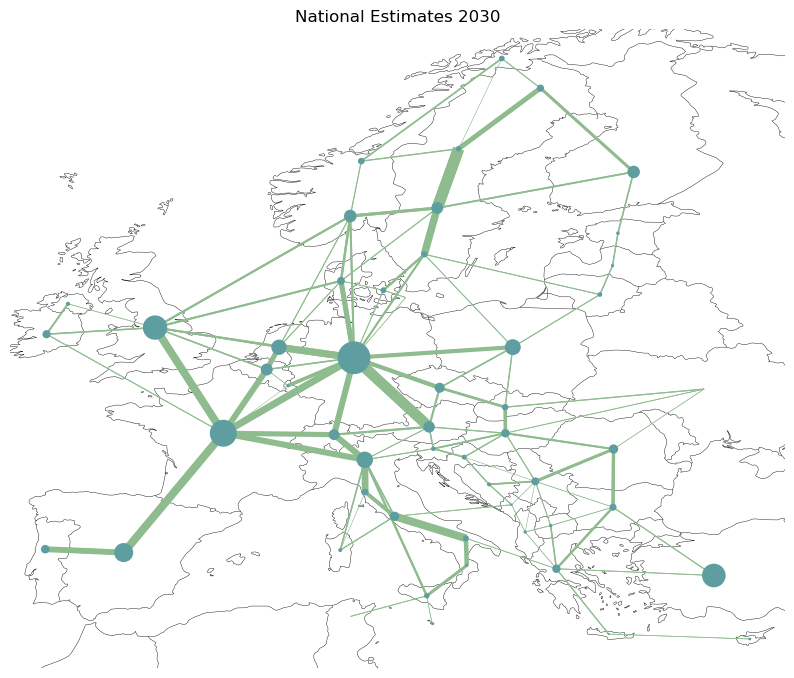

In [80]:
n4plotting = network.copy()
n4plotting.mremove('Bus', names=n4plotting.buses.index[n4plotting.buses.x.isna()])

fig, ax = plt.subplots(1,subplot_kw={"projection":ccrs.PlateCarree()})
fig.set_size_inches(10,10)
n4plotting.plot(bus_sizes=n4plotting.loads_t.p_set.groupby(n4plotting.loads.bus, axis=1).sum().mean()/1e5, link_widths=n4plotting.links.p_nom.fillna(0)/1e3, ax=ax)
ax.set_title(f'National Estimates {TY}')
plt.savefig(f'nodal-loads-National_Estimates_{TY}.jpg')

(<matplotlib.collections.PatchCollection at 0x7f5e6c9c77d0>,
 <matplotlib.collections.LineCollection at 0x7f5e6b2dfa10>)

/home/brschy/mambaforge/envs/destine/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


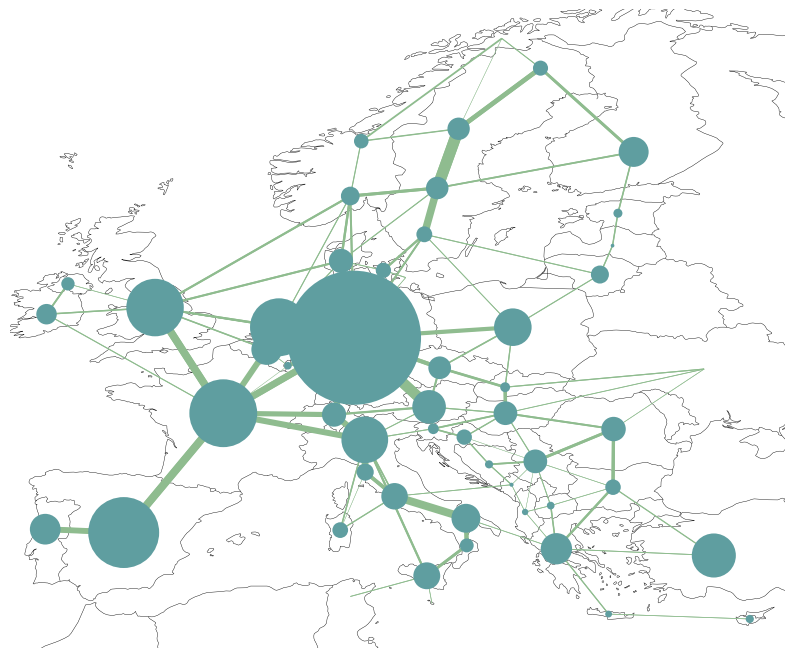

In [81]:
onwind_cap = n4plotting.generators.p_nom[n4plotting.generators.carrier=='onwind'].groupby(n4plotting.generators.bus).sum()
solar_cap = n4plotting.generators.p_nom[n4plotting.generators.carrier=='solar'].groupby(n4plotting.generators.bus).sum()
vre_cap = onwind_cap + solar_cap

fig, ax = plt.subplots(1,subplot_kw={"projection":ccrs.PlateCarree()})
fig.set_size_inches(10,10)
n4plotting.plot(bus_sizes=vre_cap/2e4, link_widths=n4plotting.links.p_nom.fillna(0)/1e3, ax=ax)

AssertionError: The first MultiIndex level of bus_sizes must contain buses

/home/brschy/mambaforge/envs/destine/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


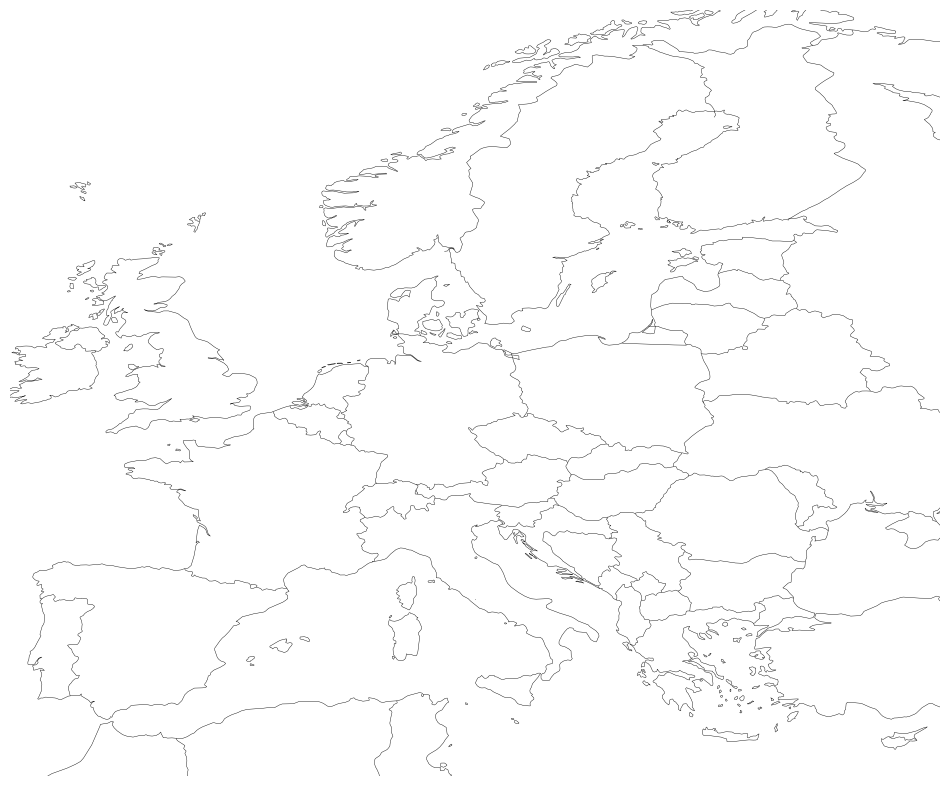

In [82]:
n4plotting.carriers.color = plt.cm.tab20.colors[:len(n4plotting.carriers.index)]

proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=n4plotting.carriers.color[car]) 
for car in n4plotting.carriers.index]

sizes = n4plotting.generators.p_nom.groupby([n4plotting.generators.bus, n4plotting.generators.carrier]).sum()
sizes = pd.concat([sizes, n4plotting.storage_units.p_nom.groupby([n4plotting.storage_units.bus, n4plotting.storage_units.carrier]).sum()])
sizes.index = sizes.index.remove_unused_levels()#.index.levels[0]#.isin(n4plotting.buses.index)

fig, ax = plt.subplots(1,subplot_kw={"projection":ccrs.PlateCarree()})
fig.set_size_inches(12,12)

n4plotting.plot(bus_sizes=sizes/1e5, link_widths=n4plotting.links.p_nom.fillna(0)/1e3, ax=ax)

ax.legend(proxy, n4plotting.carriers.index, loc='lower left', bbox_to_anchor=(0.05,-0.05), ncol=4)
ax.set_title(f'National Estimates {TY}')

plt.savefig(f'capacity-layout-National_Estimates_{TY}.jpg')